<a href="https://colab.research.google.com/github/giuliaamos/introML/blob/main/IML_tutorial_08_04_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Basics Tutorial 08.04.2022
We woul like to invistigate ability neural network with 1 hidden layer to approximate $sin(x)$ from [$-\pi$,$\pi$]. \\
In particular we are interested in the answering the following questions:
1.  Could	we	do	it	with	2-layer	NN?	How many neurons do	we	need in	the hidden	layer? How solution have been changing over	iterations?
2.  What activation function is better?
4.  What can we say about generalization outside	of	training	domain?
5.   What	loss can	we	use?	What	should	we	choose	in	case	outliers

In [ ]:
#Import neccessary modules
%matplotlib inline
import torch
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
  import os
  import imageio
  from IPython.display import Image

In [ ]:
from torch.nn.modules.activation import Tanh
# Fix all the sources of randomness to provide reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. The Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
# The Flatten layer flatens the output of the linear layer to a 1D tensor,
# to match the shape of `y`.


class SinusApproximator:
  
  def __init__(self, hidden_layer_neurons_num,activation_function):
    
    self.hidden_layer_neurons_num=2,
    if activation_function=="Tanh":
      activation_function=torch.nn.Tanh()
    elif activation_function=="Sigmoid":
      activation_function=torch.nn.Sigmoid()
    elif activation_function=="ReLU":
      activation_function=torch.nn.ReLU()
    elif activation_function=="ReLU6":
      activation_function=torch.nn.ReLU6()
    elif activation_function=="SELU":
      activation_function=torch.nn.SELU()
    
    # Create model
    self.model = torch.nn.Sequential(
        torch.nn.Linear(1, hidden_layer_neurons_num),
        activation_function,
        torch.nn.Linear(hidden_layer_neurons_num,1),
        torch.nn.Flatten(0, 1)
    )

  def train(self, data_x, data_y, epochs_num=2000,\
              learning_rate=1e-5,\
              loss_function="L2",\
  ):
    
    
    # Create Tensors to hold input and outputs.
    self.x_train = data_x
    self.y_train = data_y
    self.xx = self.x_train.unsqueeze(-1)
    
    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    if loss_function=="L1":
      loss_fn = torch.nn.L1Loss(reduction='sum')
    elif loss_function=="L2":
      loss_fn = torch.nn.MSELoss(reduction='sum')

    self.predictions = []
    self.losses = []

    for t in range(int(epochs_num)):

        # Forward pass: compute predicted y by passing x to the model. Module objects
        # override the __call__ operator so you can call them like functions. When
        # doing so you pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        y_pred = self.model(self.xx)

        # Compute and print loss. We pass Tensors containing the predicted and true
        # values of y, and the loss function returns a Tensor containing the
        # loss.
        loss = loss_fn(y_pred, self.y_train)
      
        # Zero the gradients before running the backward pass.
        self.model.zero_grad()

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()

        # Update the weights using gradient descent. Each parameter is a Tensor, so
        # we can access its gradients like we did before.
        with torch.no_grad():
            for param in self.model.parameters():
                param -= learning_rate * param.grad
        
        #Collect losses
        self.losses.append(loss.detach())
        #Log it
        if t % 1000 == 0:
            print("Epoch",t,"/",int(epochs_num),"Loss is:",loss.item())
            self.predictions.append(y_pred.detach())

  #This function is used to visualize our prediction
  def predict(self, data_x):
    self.model.eval()
    data_x=data_x.unsqueeze(-1)
    prediction = self.model(data_x)
    prediction = prediction.detach()
    return prediction

  def visulize_prediction(self, x_data, y_data_gt, y_data_pred, y_min=-1.01, y_max=1.01):
    plt.figure(figsize=(10,6))
    plt.plot(x_data, y_data_pred, c="red",label="learned function")
    plt.plot(x_data, y_data_gt, label="original function")
    plt.xlim(x_data[0]-0.01,x_data[-1]+0.01)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.show()
    plt.close()

  #This function is used to visualize our loss
  def plot_loss(self):
    plt.figure(figsize=(10,6))
    plt.plot(self.losses, label="loss dynamic durign trainig")
    plt.legend()
    plt.show()
    plt.close()


  # This function is used to create animation of training dynamic
  def create_visualization_of_training_dynamic(self, y_min=-1.01, y_max=1.01):
    !rm -rf training_dynamic
    !mkdir training_dynamic
    !rm training_dynamic2.gif
    i=0
    for p in tqdm(self.predictions):
      plt.figure(figsize=(10,6))
      plt.plot(self.x_train,p,c="red",label="learned function at step "+str(int(i*1e3)))
      plt.plot(self.x_train,self.y_train,label="original function")
      plt.xlim(self.x_train[0],self.x_train[-1])
      plt.ylim(y_min,y_max)
      plt.legend()
      if i<=9:
        plt.savefig("training_dynamic/00"+str(i)+".png")
      elif i<=99:
        plt.savefig("training_dynamic/0"+str(i)+".png")
      plt.close()
      i+=1
    with imageio.get_writer('training_dynamic2.gif', mode='I') as writer:
      for filename in tqdm(sorted(os.listdir("training_dynamic/"))):
          image = imageio.imread(os.path.join("training_dynamic/",filename))
          writer.append_data(image)

In [ ]:
#Let's generate our data
x_data = torch.linspace(-math.pi, math.pi, 2000)
y_data_gt = torch.sin(x_data)

## Question 1: Could	we	approximate $sin(x)$ from [$-\pi$,$\pi$] it	with	2-layer	NN?	How many neurons do	we	need		in	the hidden	layer?

Try different number of neurons below (by comment/uncomment appropriate lines)

In [ ]:
sin_approx = SinusApproximator(2,"Sigmoid")
#sin_approx = SinusApproximator(10,"Sigmoid")
#sin_approx = SinusApproximator(20,"Sigmoid")

In [ ]:
# Let create model
sin_approx.train(x_data, y_data_gt, 1e5,1e-5,"L2")

#Let's visualize plots
sin_approx.plot_loss()
y_data_pred = sin_approx.predict(x_data)

sin_approx.visulize_prediction(x_data, y_data_gt, y_data_pred)

#Let's visulize dynamic of training
sin_approx.create_visualization_of_training_dynamic()
Image(open('training_dynamic2.gif','rb').read())



This cell output is too large and can only be displayed while logged in.


## Question 2. What activation function is better?

Try different functions below and observe the difference

In [ ]:
sin_approx = SinusApproximator(20,"Tanh")
#sin_approx = SinusApproximator(20,"ReLU")
#sin_approx = SinusApproximator(20,"ReLU6")
#sin_approx = SinusApproximator(20,"SELU")

In [ ]:
# Let create model
sin_approx.train(x_data, y_data_gt, 1e5,1e-6,"L1")

#Let's visualize plots
sin_approx.plot_loss()
y_data_pred = sin_approx.predict(x_data)
sin_approx.visulize_prediction(x_data, y_data_gt, y_data_pred)

#Let's visulize dynamic of training
sin_approx.create_visualization_of_training_dynamic()
Image(open('training_dynamic2.gif','rb').read())

This cell output is too large and can only be displayed while logged in.


## Question 3. Do we have generalization outside of	training domain?

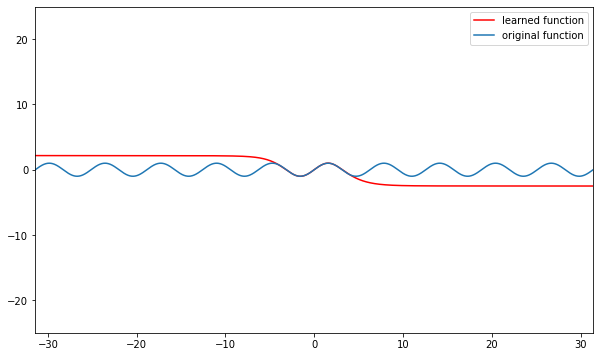

In [ ]:
x_data = torch.linspace(-10*math.pi, 10*math.pi, 4000)
y_data_gt = torch.sin(x_data)
y_data_pred = sin_approx.predict(x_data)
sin_approx.visulize_prediction(x_data, y_data_gt, y_data_pred,-25,25)

## Question 4. What	loss function can	we	use?	What	should	we	choose	in	case	outliers?



In [ ]:
#Let's generate data with outliers
x_data = torch.linspace(-math.pi, math.pi, 4000)
y_data_gt = torch.sin(x_data)
y_data_gt[998:1002] = 100
y_data_gt[1998:2002] = -100
y_data_gt[2998:3002] = 100

Epoch 0 / 100000 Loss is: 122385.890625
Epoch 1000 / 100000 Loss is: 119846.5390625
Epoch 2000 / 100000 Loss is: 119460.5625
Epoch 3000 / 100000 Loss is: 119311.2421875
Epoch 4000 / 100000 Loss is: 119241.8125
Epoch 5000 / 100000 Loss is: 119214.3125
Epoch 6000 / 100000 Loss is: 119202.2734375
Epoch 7000 / 100000 Loss is: 119193.796875
Epoch 8000 / 100000 Loss is: 119184.171875
Epoch 9000 / 100000 Loss is: 119172.1328125
Epoch 10000 / 100000 Loss is: 119157.171875
Epoch 11000 / 100000 Loss is: 119138.453125
Epoch 12000 / 100000 Loss is: 119115.328125
Epoch 13000 / 100000 Loss is: 119087.828125
Epoch 14000 / 100000 Loss is: 119056.5703125
Epoch 15000 / 100000 Loss is: 119022.65625
Epoch 16000 / 100000 Loss is: 118987.375
Epoch 17000 / 100000 Loss is: 118952.171875
Epoch 18000 / 100000 Loss is: 118918.484375
Epoch 19000 / 100000 Loss is: 118887.46875
Epoch 20000 / 100000 Loss is: 118859.953125
Epoch 21000 / 100000 Loss is: 118836.3671875
Epoch 22000 / 100000 Loss is: 118816.703125
Epoch 

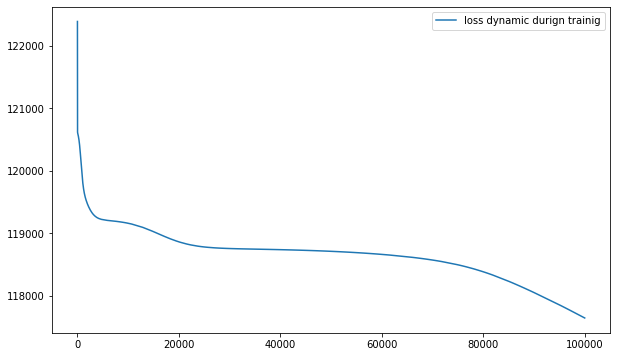

In [ ]:
# Create model
sin_approx = SinusApproximator(20,"Sigmoid")
sin_approx.train(x_data, y_data_gt, 1e5,1e-5,"L2")

#Let's visualize plots
sin_approx.plot_loss()
y_data_pred = sin_approx.predict(x_data)

In [ ]:
sin_approx.visulize_prediction(x_data, y_data_gt, y_data_pred, -100, 100)

#Let's visulize dynamic of training
sin_approx.create_visualization_of_training_dynamic(-100,100)
Image(open('training_dynamic2.gif','rb').read())

This cell output is too large and can only be displayed while logged in.


Let's zoom in to found training artefacts

In [ ]:
sin_approx.visulize_prediction(x_data, y_data_gt, y_data_pred, -5, 5)
#Let's visulize dynamic of training
sin_approx.create_visualization_of_training_dynamic(-5,5)
Image(open('training_dynamic2.gif','rb').read())

This cell output is too large and can only be displayed while logged in.


Let's train the same model but with L1 loss and observe the difference (imroved robustness in relation to outliers in training dataset)

Epoch 0 / 100000 Loss is: 3733.416015625
Epoch 1000 / 100000 Loss is: 1714.2314453125
Epoch 2000 / 100000 Loss is: 1519.777099609375
Epoch 3000 / 100000 Loss is: 1494.9674072265625
Epoch 4000 / 100000 Loss is: 1638.8004150390625
Epoch 5000 / 100000 Loss is: 1591.595458984375
Epoch 6000 / 100000 Loss is: 1637.97119140625
Epoch 7000 / 100000 Loss is: 1652.64404296875
Epoch 8000 / 100000 Loss is: 1654.556396484375
Epoch 9000 / 100000 Loss is: 1440.5030517578125
Epoch 10000 / 100000 Loss is: 1633.5078125
Epoch 11000 / 100000 Loss is: 1395.997802734375
Epoch 12000 / 100000 Loss is: 1634.8382568359375
Epoch 13000 / 100000 Loss is: 1635.8465576171875
Epoch 14000 / 100000 Loss is: 1604.8095703125
Epoch 15000 / 100000 Loss is: 1389.110595703125
Epoch 16000 / 100000 Loss is: 1579.9400634765625
Epoch 17000 / 100000 Loss is: 1555.02685546875
Epoch 18000 / 100000 Loss is: 1573.9586181640625
Epoch 19000 / 100000 Loss is: 1367.85546875
Epoch 20000 / 100000 Loss is: 1539.0927734375
Epoch 21000 / 10000

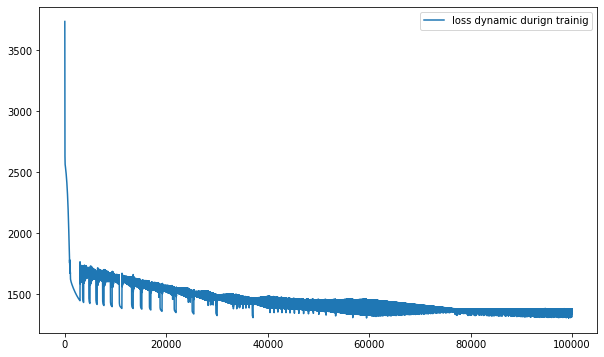

In [ ]:
# Create model
sin_approx = SinusApproximator(20,"Sigmoid")
sin_approx.train(x_data, y_data_gt, 1e5,1e-5,"L1")

#Let's visualize plots
sin_approx.plot_loss()
y_data_pred = sin_approx.predict(x_data)

In [ ]:
sin_approx.visulize_prediction(x_data, y_data_gt, y_data_pred, -5, 5)

#Let's visulize dynamic of training
sin_approx.create_visualization_of_training_dynamic(-5,5)
Image(open('training_dynamic2.gif','rb').read())

This cell output is too large and can only be displayed while logged in.
